## Module 1 : Fetch Data

In [1]:
# Import modules
# Read data
import os
import sys
import pickle

# Dataframes
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import concat
# display and formatting
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly

# Config
folder = './data/'
train = 'train_aWnotuB.csv'
test = 'test_BdBKkAj_L87Nc3S.csv'
sub = 'sample_submission_KVKNmI7.csv'


def _ReadCsv_pd(datafolder, file):
    """Read CSV file from remote path.
    Returns:
      The contents of CSV file.
    Raises:
      ValueError: Unable to read file
    """
    try:
        df = pd.read_csv(os.path.join(datafolder, file))
        print(file, ": Read csv to dataframe sucessfully")
        print("Shape of dataframe", df.shape, "Memory Usage", sys.getsizeof(df))
    except Exception as e:
        raise type(e)(e)
        exit()
    return(df)


# df_copy = df.copy()

def __GetTimeSeriesCount(df, col_name):
    try:
        print(pd.concat(g for _, g in df.groupby() if len(g) > 1))
        
    except:
        print("Dataframe is single timeseries")
    return()


def __SetColumnNames(df, id_col, ds_col, target_col):
    df.rename(columns={ds_col: 'ds', id_col : 'ID', target_col : 'y'}, inplace=True)
#     df.set_index('ds', drop = False, inplace = True)
    return(df)

# Fix in train
train = _ReadCsv_pd(folder, train)
__GetTimeSeriesCount(train,"DateTime")
df = __SetColumnNames(train, id_col = 'ID', ds_col = 'DateTime', target_col = 'Vehicles')

#Fix in test
test = _ReadCsv_pd(folder, test)
__GetTimeSeriesCount(test,"DateTime")
test = __SetColumnNames(test, id_col = 'ID', ds_col = 'DateTime', target_col = 'Vehicles')

df.head()


train_aWnotuB.csv : Read csv to dataframe sucessfully
Shape of dataframe (48120, 4) Memory Usage 4812160
Dataframe is single timeseries
test_BdBKkAj_L87Nc3S.csv : Read csv to dataframe sucessfully
Shape of dataframe (11808, 3) Memory Usage 1086496
Dataframe is single timeseries


,ds,Junction,y,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


## Module 2 : Clean Data

In [2]:
def __GetIntCols(df, collist):
    for col in collist:
        df[col] = df[col].str.extract('(\d+)').astype(float)
    return(df)

def get_prop_missing_values(df):
    print("Null info in data: ", df.isna().any().sum())
    #prop_missing = round((df[df.columns[:]].isnull().sum()/df[df.columns[:]].count())*100,4)
    prop_missing = round((df.isnull().sum()/len(df))*100,2)
    print("These are the missing values proportions in each column")
    print(prop_missing)
    return()


def __SetColumnTypes(df, change_to_int_list = ['col1']):
    cols = df.columns
    try:
        df = __GetIntCols(df, change_to_int_list)
    except:
        pass
    # Check for any null values in the data
    print("% Missing data in each column \n",get_prop_missing_values(df))
    return(df, cols)


# For this particular dataframe

df['ds'] = pd.to_datetime(df['ds'])
clean_df, cols = __SetColumnTypes(df)

# Get list of column by types
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(cols) - set(num_cols))
cat_cols.remove('ds')
print(cat_cols)

Null info in data:  0
These are the missing values proportions in each column
ds         0.00
Junction   0.00
y          0.00
ID         0.00
dtype: float64
% Missing data in each column 
 ()
[]


In [3]:
def __CheckMissingTimeSteps(dfs, group_col):
    tdf = pd.DataFrame({'date': pd.date_range(start='2015-11-01 00:00:00', end='2017-06-30 23:00:00', freq='H')})
    len_tdf = len(tdf)
    vals = dfs[group_col].unique()
    for i in vals:
        if len(dfs[dfs[group_col] == i]) == len_tdf:
            print("No missing timesteps for group", i)
        else:
            print("Missing timesteps for group", i)
            print("Group len VS Timesteps")
            print(len(dfs[dfs[group_col] == i]), len_tdf)
    return()

__CheckMissingTimeSteps(clean_df, group_col='Junction')

#Since we see missing timesteps in group 4, we checked and found that group4 started at later date. Checking again:

def __CheckMissingTimeSteps(dfs, group_col):
    tdf = pd.DataFrame({'date': pd.date_range(start='2017-01-01 00:00:00', end='2017-06-30 23:00:00', freq='H')})
    len_tdf = len(tdf)
    vals = dfs[group_col].unique()
    for i in vals:
        if len(dfs[dfs[group_col] == i]) == len_tdf:
            print("No missing timesteps for group", i)
        else:
            print("Missing timesteps for group", i)
            print("Group len VS Timesteps")
            print(len(dfs[dfs[group_col] == i]), len_tdf)
    return()

__CheckMissingTimeSteps(clean_df[clean_df['Junction'] == 4], group_col='Junction')

No missing timesteps for group 1
No missing timesteps for group 2
No missing timesteps for group 3
Missing timesteps for group 4
Group len VS Timesteps
4344 14592
No missing timesteps for group 4


()

## Module 3 : Pre-Proccess Model Data

In [4]:
# Helper functions
# Split dataframe
def __SplitTrainTest(X, prop = 0.95):
    '''Takes in the dataframe and proprtion of train size and returns the train and test sets'''
    X.sort_values(by='ds', ascending=True, inplace = True)
    train_size = int(len(X) * prop)
    train, test = X[0:train_size], X[train_size:len(X)]
    print("Min date train main", train.ds.min(), "Max date train main", train.ds.max())
    print("Min date test main", test.ds.min(), "Max date test main", test.ds.max())
    print("Length of train", len(train), "Length of test", len(test))
    return(train, test)


train_df, test_df = __SplitTrainTest(clean_df, prop = 0.80)

Min date train main 2015-11-01 00:00:00 Max date train main 2017-03-22 17:00:00
Min date test main 2017-03-22 18:00:00 Max date test main 2017-06-30 23:00:00
Length of train 38496 Length of test 9624


## Module 4 : Exploratory Data Analysis

Distribution for
a
Cat col not found


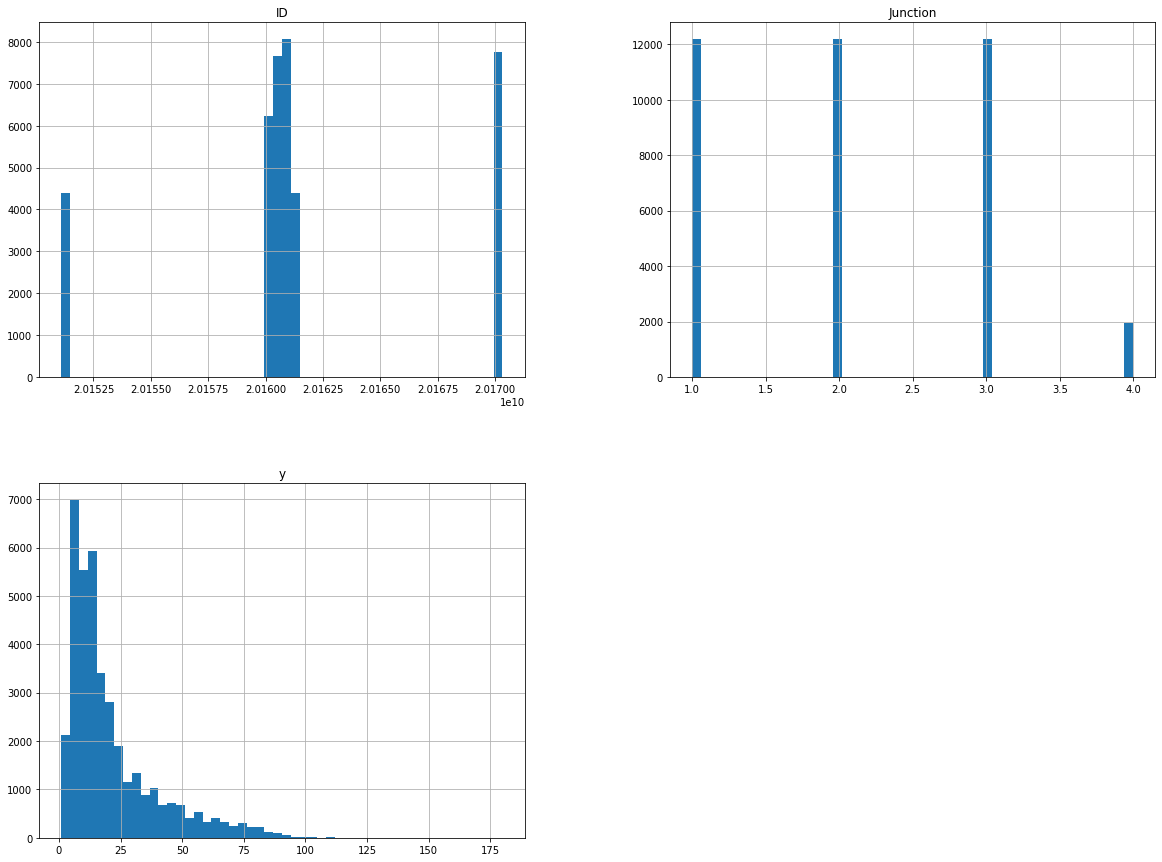

,Junction,y,ID
count,38496.00,38496.00,38496.00
mean,2.10,21.17,20161503534.75
std,0.91,18.43,5290818.03
min,1.00,1.00,20151101001.00
25%,1.00,9.00,20160313159.00
50%,2.00,15.00,20160725077.00
75%,3.00,27.00,20161205425.00
max,4.00,180.00,20170322174.00


In [5]:
def __ExploringDataframe(df, cat_list= ['a']):
    try:
        for col in cat_list:
            print("Distribution for")
            print(col)
            print(df[col].value_counts())
    except:
        print("Cat col not found")
    # Above data as plots
    df.hist(bins=50, figsize=(20,15))
    plt.show()
    return()

__ExploringDataframe(train_df)
# Lets look at the rest of the fields - we can check out the numeric data using describe method
train_df.describe()

## Module 5 : Prepare Model Data

In [22]:
# Make changes on read test data

full_test = test.copy()
full_test.set_index('ds', drop = False, inplace = True)
full_test_id = full_test["ID"].copy()
full_test = full_test.drop(["ID"], axis = 1)
full_test_1 = full_test[full_test['Junction'] == 1]

In [23]:
tr_df = train_df.copy()
ts_df = test_df.copy()

tr_df.set_index('ds', drop = False, inplace = True)
ts_df.set_index('ds', drop = False, inplace = True)


tr_id = tr_df["ID"].copy()
tr_df = tr_df.drop(["ID"], axis = 1)

ts_id = ts_df["ID"].copy()
ts_df = ts_df.drop(["ID"], axis = 1)

In [24]:
data_tr = tr_df[tr_df['Junction'] == 1]
data_ts = ts_df[ts_df['Junction'] == 1]

In [25]:
# for i in tr_df.Junction.unique().tolist():
#     plt.plot(tr_df[tr_df['Junction'] == i].Vehicles)

## Module 6: Exploring Time Series

In [26]:
data_ts = data_ts.drop(["Junction"], axis = 1)
data_ts.head()

,ds,y
ds,,
2017-03-22 18:00:00,2017-03-22 18:00:00,91
2017-03-22 19:00:00,2017-03-22 19:00:00,101
2017-03-22 20:00:00,2017-03-22 20:00:00,98
2017-03-22 21:00:00,2017-03-22 21:00:00,96
2017-03-22 22:00:00,2017-03-22 22:00:00,91


In [27]:
data_tr = data_tr.drop(["Junction"], axis = 1)
data_tr.head()

,ds,y
ds,,
2015-11-01 00:00:00,2015-11-01 00:00:00,15
2015-11-01 01:00:00,2015-11-01 01:00:00,13
2015-11-01 02:00:00,2015-11-01 02:00:00,10
2015-11-01 03:00:00,2015-11-01 03:00:00,7
2015-11-01 04:00:00,2015-11-01 04:00:00,9


In [28]:
from fbprophet import Prophet

In [29]:
future_df = ts_df.copy()

m1 = Prophet()
#add regressors
# for feature in regressors_ls:
#     m1.add_regressor(feature)
    
m1.fit(data_tr)


forecast1 = m1.predict(data_ts)
print("Model trained")


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Model trained


In [36]:
# fig1 = m1.plot(forecast1)
# fig2 = m1.plot_components(forecast1)

In [ ]:
def __PrepModelDf(model_df):
    df = model_df.copy()
    df.set_index('ds', drop = False, inplace = True)
    df_id = df["ID"].copy()
    df = df.drop(["ID"], axis = 1)
    df = df.drop(["Junction"], axis = 1)
    return(df, df_id)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def __GetError(test, forecast):
    actual = pd.Series(test['y'])
    actual = actual.tolist()
    predictions = forecast['yhat']
    forecast['actual'] = actual
    min_val = min(actual)
    forecast['yhat'] = np.where(forecast['yhat'] < 0, min_val, forecast['yhat'])
    mape = mean_absolute_percentage_error(actual, forecast['yhat'])
    print(mape)
    return()


def __PlotPrediction(train, test, forecast):
    fig = plt.figure(facecolor='w', figsize=(20, 6))
    plt.plot(train.ds, train.y,  label='Train')
    plt.plot(test.ds, test.y,  label='Test')
    plt.plot(test.ds, forecast['yhat'],  label='Predicted')
    plt.show()
    return()


In [31]:
def __ProphetFit(train, test):
    '''Fits the prophet model on '''
    ls = []
#     for Cntry in data_grp.Country.unique().tolist():
    for i in train.Junction.unique().tolist():
        print(i)
        tr_i = train[train['Junction'] == i]
        ts_i = test[test['Junction'] == i]
        
        # Prep Data
        tr_df, tr_id = __PrepModelDf(tr_i)
        ts_df, ts_id = __PrepModelDf(ts_i)

        #Fit model
        m1 = Prophet()
        m1.fit(tr_df)


        forecast_df = m1.predict(ts_df)
        print("Model trained")
        # Plots
        __GetError(ts_df, forecast_df)
        __PlotPrediction(tr_df, ts_df, forecast_df)
        
        forecast_df['ID'] = list(ts_id)
        forecast_df['Junction'] = i
        return(forecast_df)

20.5122832814662


()

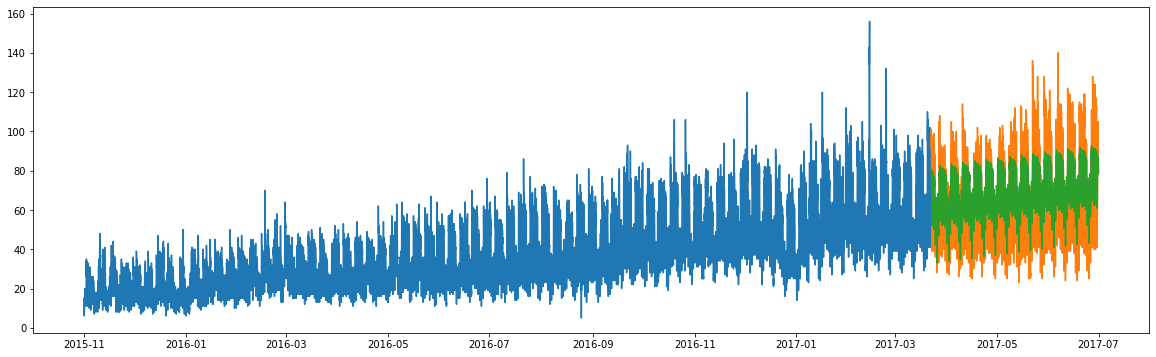

()

In [34]:
# Plots
__GetError(data_ts, forecast1)
__PlotPrediction(data_tr, data_ts, forecast1)

In [ ]:

for i in tr_df.Junction.unique().tolist():
    ts = tr_df[tr_df['Junction'] == i]['Vehicles']
    test_stationarity(ts)


p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
#Method 3 – Moving Average
for i in tr_df.Junction.unique().tolist():
    tri_df = tr_df[tr_df['Junction'] == i].copy()
    tsi_df = test_df[test_df['Junction'] == i].copy()
    y_hat_avg = tsi_df.copy()
    y_hat_avg['moving_avg_forecast'] = tri_df['Vehicles'].rolling(60).mean().iloc[-1]
    
    error = mean_absolute_percentage_error(tsi_df['Vehicles'], y_hat_avg['moving_avg_forecast'])
    
    print("Error", error)
    plt.figure(figsize=(16,8))
    plt.plot(tri_df['ds'], tri_df['Vehicles'], label='tri_df')
    plt.plot(tsi_df['ds'], tsi_df['Vehicles'], label='tsi_df')
    plt.plot(tsi_df['ds'], y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
    plt.legend(loc='best')
plt.show()

## Module 7 : Fit Trained Model

In [ ]:
test_df = _ReadCsv_pd(folder, test)

print("Junctions predict for test", test_df.Junction.unique())
print("Dates to predict for test", test_df.DateTime.min(), test_df.DateTime.max())

In [ ]:
ls = []
for i in clean_df.Junction.unique().tolist():
    tri_df = clean_df[clean_df['Junction'] == i].copy()
    tsi_df = test_df[test_df['Junction'] == i].copy()
    y_hat_avg = tsi_df.copy()
    y_hat_avg['moving_avg_forecast'] = tri_df['Vehicles'].rolling(60).mean().iloc[-1]
    ls.append(y_hat_avg)

In [ ]:
df = pd.concat(ls)
len(df)

In [ ]:
len(test_df)

## Module 9 : Predict

In [ ]:
sub_df = _ReadCsv_pd(folder, sub)

In [ ]:
submission1 = df[['ID', 'moving_avg_forecast']]
submission1.rename(columns={'moving_avg_forecast': 'Vehicles'}, inplace=True)
submission1.head()

In [ ]:
output_directory = "./submissions/"
submission1.to_csv(output_directory + "ruhama_submission2.csv", index=False)